<a id='import_libraries'></a>
## 1. Import libraries

Back to the [top](#top)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import nltk
from IPython.display import HTML

<a id='generate_links'></a>
## 2. Generate links to all search results pages

Back to the [top](#top)

#### Starting page:

In [4]:
URL_1 = 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start'
HTML(URL_1)

---

### Generate the list containing URLs of all pages with search results for a 'Business Management Analyst'

Function `'get_all_search_pages'` is defined and used to generate a `'List_of_all_URLs'`.

In [38]:
def get_all_search_pages(URL_1):
    """
    function to generate links to all subsequent search results pages
    
    Input arguments: 'URL_1'   -- str  -- starting page URL, a page from search results
    
    Returns: 'List_of_all_URLs' -- list -- list of all subsequent URLs 
             'total_results'    -- int  -- total number of jobs postings found
             
    
    returns a list of URLs of all search results pages
    """

    # get the HTML of the first search results page
    r = requests.get(URL_1)
    content = r.text

    # make a soup out of the first page of search results
    soup_1 = BeautifulSoup(content, 'lxml')

    # extract the number of search results
    num_results_str = soup_1.find('div', {'id':'searchCount'}).text
    # parse the string and extract the total number (4th element), replace comma with an empty space, convert to int
    total_results = int(num_results_str.split()[3].replace(',', ''))

    # add the common part between all search pages
    next_pages_links = "https://www.indeed.ca" + soup_1.find('div', {'class': 'pagination'}).find('a').get('href')[:-2]

    print(next_pages_links)

    # create empty list to store URLs of all search results pages 
    List_of_all_URLs = []

    # add the first page to the 'List_of_all_URLs'
    List_of_all_URLs.append(next_pages_links)

    # add different starting positions for subsequent search results pages to 'List_of_all_URLs'
    for start_position in range(20,total_results,20):
        List_of_all_URLs.append(next_pages_links+str(start_position))
    
    return List_of_all_URLs, total_results

List_of_all_URLs, total_results = get_all_search_pages(URL_1)
print("\n{0} links with search results pages generated and saved to 'List_of_all_URLs'.".format(len(List_of_all_URLs)) +
      " Search returned a total of {0} results\n".format(total_results))
List_of_all_URLs

https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=

156 links with search results pages generated and saved to 'List_of_all_URLs'. Search returned a total of 3118 results



['https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=20',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=40',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=60',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=80',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=100',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=120',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=140',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=160',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=180',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada&start=200',
 'https://www.indeed.ca/jobs?q=data+business+management+analyst&l=Canada

<a id='scraping_html'></a>
## 3. Scraping the job details

Back to the [top](#top)

List of all search results pages is used to scrape details about each posting.


* `'List_of_all_URLs'` generated by the function `'get_all_search_results'` is fed into the function `'scrape_job_links_and_info'`
* each page of job search results is parsed for < div > tags containing links to individual job postings
* function `'scrape_job_links_and_info'` feeds lists of < div > tags into the function `'scrape_job_info'`
* function `'scrape_job_info'` gets HTML code of each job posting and saves it as a **(key) -- (value)** pair of **(link to posting) -- (its HTML code)** 
* results are saved to a global dictionary `'scraping_results_dict'`

In [24]:
%%time

scraping_results_dict = {} # this is a global dict used by 'scrape_job_info' to store scraping results to be parsed later


def scrape_job_info(job_search_results):
    """
    function to scrape individual job pages from indeed.ca
    used by the function 'scrape_job_links_and_info'
    
    scrapes individual job postings and saves results 
    as 'key'-'value' pairs of 'link'-'HTML of job posting'
    to a global dictionary 'scraping_results_dict'
    
    Input arguments: job_search_results -- list -- list of <div> tags with job postings 
                                                   from a search results page
    """
    global scraping_results_dict    # dict used to store results of scrapping
    
    # loop over all <div> tags supplied by the function 'scrape_job_links_and_info'
    for x in job_search_results:
        
        # extract the individual job posting link from a <div> tag
        job_link = "https://www.indeed.ca" + x.find('a')['href']
        
        # get the HTML code from the job posting page and save it as text to 'scrapping_results_dict'
        # link to the job posting is used as a key and HTML code of the job posting as a value
        job_html = requests.get(job_link)
        scraping_results_dict[job_link] = job_html.text
        
        # sleep for 0.5 second, to avoid too many requests to the indeed.ca server
        time.sleep(0.5)


def scrape_job_links_and_info(List_of_all_URLs):
    """
    function to scrape individual job postings 
    (via another function 'scrape_job_info')
    
    gets HTML of each search page from the list 
    generated by the function 'get_all_search_pages',
    parses links to individual job postings 
    from search results pages, and feeds them
    to function 'scrape_job_info'
        
    Input arguments: 'List_of_all_URLs'   -- list  -- list containing URLs of all pages with job search results    
    """
    # loop over all pages in 'List_of_all_URLs' to extract links to each job posting
    for page_url in List_of_all_URLs:
        
        # get the HTML of the search results page
        page = requests.get(page_url)
        content = page.text
        # make a soup out of the HTML
        soup = BeautifulSoup(content, 'lxml')
        
        # find all <div> tags containing each job posting links and feed them to the function 'scrape_job_info'
        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row sjlast result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard lastRow row result'})
        scrape_job_info(results)
    
    print("Done!")

# run function 'scrape_job_links_and_info' to scrape every job posting from search results pages in 'List_of_all_URLs'
scrape_job_links_and_info(List_of_all_URLs)
print("{0} job postings have been scraped and saved to 'scraping_results_dict'.".format(len(scraping_results_dict)))

Done!
1065 job postings have been scraped and saved to 'scraping_results_dict'.
Wall time: 28min 9s


In [25]:
len(scraping_results_dict)

1065

<a id='parsing_jobs'></a>
## 4. Parsing job postings

Back to the [top](#top)

Job details and mentioned skills are parsed from each job posting scraped previously by the function `'scrape_job_links_and_info'`.

* `'skill_keywords_dict'` is defined: category of skills and corresponding lists of keywords
* function `'parse_job_info'` is run:
    * takes the dictionary with scraped job postings as input
    * loops over the key(link)--value(HTML code) pairs
    * uses BeautifulSoup to extract job details from HTML tags
    * uses `'skills_keywords_dict'` to check keywords mentioned in job descriptions
    * saves results to `'results_dict'`
* `'resutls_dict'` is converted to a DataFrame, DataFrame is transposed, index is reset to a range index.

In [26]:
%%time

results_dict = {}   # empty dictionary to store results of parsing of job pages

# dictionary with skills used to parse job descriptions, categories become columns in 'results_df'
skills_keywords_dict = {'CRM':['CRM'],
                        'CPA':['CPA'],
                        'business analysis':['business analysis','business analyst','business analyze','system analysis'],
                        'business modeling':['business modeling','business model'],
                        'business management':['business management','business manage'],
                        'marketing':['marketing'],
                        # tech skills
                        'Excel': ['Excel'],
                        'data modeling':['data modeling'],
                        'process modeling':['process modeling'],
                        'Python': ['Python'],
                        'VBA':['VBA'],
                        'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
                        'Ruby': ['Ruby'],
                        'Java/Scala': ['Java', 'JVM', 'Scala'],
                        'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                        'MATLAB': ['MATLAB'],
                        'SAS': ['SAS'],
                        'SQL/databases': ['SQL', 'databases'],
                        'SPSS': ['SPSS'],
                        'Stata': ['Stata'],
                        'RapidMiner': ['RapidMiner', 'Rapid Miner'],
                        'Machine Learning': ['Machine Learning', 'ML'],
                        'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics'],
                        'NLP': ['Natural Language Processing', 'NLP'],
                        'Visualisation': ['Visualisation', 'Visualization'],
                        'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive', 
                                     'beam', 'Hadoop', 'MapReduce', 'Hbase'],
                        'Cloud': ['Cloud', 'AWS', 'GCP', 'Azure ', 'Google Cloud'],
                        'REST': ['REST', 'flask', 'Sinatra'],
                        'Math': ['Algebra', 'Statistics', 'Operations research'],
                        'DevOps': ['DevOps', 'TDD', 'test-driven', 'GitHub'],
                        # soft skills
                        'communication': ['communication', 'presentation'],
                        'problem solving': ['problem solving'],
                        'project_management': ['project management'],
                        'leadership': ['leadership'],
                        'consulting': ['consulting'],
                        'organizational':['organizational']
                        }


def parse_job_info(scraping_results_dict, skills_keywords_dict):
    """
    function to parse job info from previously scraped job pages
    extracts info from HTML of each job page, saves it to the dictionary 'results_dict'
    
    Input arguments: scraping_results_dict -- dictionary -- contains 'link'--'HTML code' pairs 
                                                            of job postings
                     skills_keywords_dict   -- dictionary -- contaings skills categories and 
                                                             corresponding lists of keywords
    """
    global resutls_dict    # global dict used to store results of scraping
    
    # loop over all key(link)-value(HTML code) pairs in scraping results
    for link, job_html_text in scraping_results_dict.items():
        
        # make a soup out of a job posting HTML code
        soup_job = BeautifulSoup(job_html_text, 'lxml')
        
        results_dict[link] = {} # new sub-dictionary (value) in the 'results_dict' under (key) 'link' 
        
        # extract job title from the job page
        try:
            results_dict[link]['job_title'] = soup_job.find_all('h3', 
                                {'class':"icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title"})[0].text   
        except IndexError:
            results_dict[link]['job_title'] = 'Not found'
        # extract company name
        try:
            results_dict[link]['company_name'] = soup_job.find_all('div', 
                                                                   {'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'})[0].text 
        except IndexError:
            results_dict[link]['company_name'] = 'Not found'
        # extract job location
        try:
            # get the part of the <div> tag containing location ("MindGeek 47 reviews-Montréal, QC" on top of a job posting page)
            location_line = soup_job.find_all('div', 
              {'class':"jobsearch-InlineCompanyRating icl-u-xs-mt--xs jobsearch-DesktopStickyContainer-companyrating"})[0]
            # convert the tag to string, split by '-', select the second element (contains job location)
            results_dict[link]['job_location'] = location_line.text.split('-')[1]
        except IndexError:
            results_dict[link]['job_location'] = 'Not found'
        # extract job description section
        try:
            results_dict[link]['job_description'] = soup_job.find_all('div', 
                                            {'class': 'jobsearch-JobComponent-description icl-u-xs-mt--md'})[0].text
        except IndexError:
            results_dict[link]['job_description'] = 'Not found'
        # extract date posted
        try:
            results_dict[link]['date'] = soup_job.find_all('div', 
                                                        {'class':'jobsearch-JobMetadataFooter'})[0].text.split(' - ')[1]
        except IndexError:
            results_dict[link]['date'] = 'Not found'
                
        # search for the skills
        soup_job_text = soup_job.text
        for skill_category, skills in skills_keywords_dict.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            
            category_found = 0   # variable used to store results of the intermediate check (loop below)
            
            for skill in skills:        # loop over all skills in the sublist of 'skills_keywords_dict'
                if soup_job_text.find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
            
            results_dict[link][skill_category] = category_found   # skill set to 1 if found, 0 if not, in 'resutls_dict'
        
# feed all job page HTMLs (values in 'scraping_results_dict') to function 'parse_job_info'
parse_job_info(scraping_results_dict, skills_keywords_dict)
results_df = pd.DataFrame(results_dict).T.reset_index()

Wall time: 46.4 s


#### Display the top 5 rows of the DataFrame with results

In [27]:
results_df.head()

,index,Big Data,C/C++,CPA,CRM,Cloud,Data Mining/Analytics,DevOps,Excel,Java/Scala,...,date,job_description,job_location,job_title,leadership,marketing,organizational,problem solving,process modeling,project_management
0,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,0,0,0,0,...,6 days ago,"LOCATION: Calgary, Alberta (CA-AB)\nJOB NUMBER...","Calgary, AB",IT Change Management Analyst,0,1,0,0,0,0
1,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,0,0,1,0,...,save job,"Regina, SKJOB DESCRIPTIONThe primary function ...","Regina, SK",Business Analyst/Reporting Administrator,0,0,1,1,0,0
2,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
3,https://www.indeed.ca/company/RSD-Group/jobs/B...,0,0,0,0,0,0,0,0,0,...,save job,"$60,000 - $80,000 a yearExperience in requirem...","Toronto, ON",Business Analyst/Data analyst,0,0,0,0,0,0
4,https://www.indeed.ca/rc/clk?jk=6eaac1dc724189...,0,0,0,0,0,1,0,0,0,...,11 hours ago,"$85,300 - $109,900 a yearOffice of the Superin...","Toronto, ON",Regulatory Data Analyst,0,0,1,0,0,0


<a id='duplicate_check'></a>
## 5. Checking for duplicate rows

Back to the [top](#top)

The scraping script ecounters some job postings multiple times under different links.

If a duplicate check is performed using `'all columns'` as match criteria, no duplicates are found:

In [28]:
# get the list of all columns in 'results_df'
cols_for_duplicate_check = results_df.columns

# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = results_df.duplicated(keep=False, subset=cols_for_duplicate_check)
# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
results_df[mask].sort_values(by=['job_title', 'company_name'])

,index,Big Data,C/C++,CPA,CRM,Cloud,Data Mining/Analytics,DevOps,Excel,Java/Scala,...,date,job_description,job_location,job_title,leadership,marketing,organizational,problem solving,process modeling,project_management


**However,** if the link address is removed from the match criteria, duplicate check finds many results: 

#### Example of duplicated rows (including first instances):

In [29]:
# get the list of all columns in 'results_df'
cols_for_duplicate_check = results_df.columns
# remove column 'index' (contains job posting link) from the match criteria used by the duplicate check
remove_col = ['index', 'date']
cols_for_duplicate_check = cols_for_duplicate_check.drop(remove_col)

# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = results_df.duplicated(keep=False, subset=cols_for_duplicate_check)
# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
results_df[mask].sort_values(by=['job_title', 'company_name'])

,index,Big Data,C/C++,CPA,CRM,Cloud,Data Mining/Analytics,DevOps,Excel,Java/Scala,...,date,job_description,job_location,job_title,leadership,marketing,organizational,problem solving,process modeling,project_management
2,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
122,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"The Analyst/ Senior Analyst, Portfolio Risk wi...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
318,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
415,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
442,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
489,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
541,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
567,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
591,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"The Analyst/ Senior Analyst, Portfolio Risk wi...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0
613,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...","Montréal, QC","ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",0,0,0,0,0,0


These **job postings match in everything**, including the job title, company, location, date posted, and the full text of the job description (saved in column `'job_description'`).

In [30]:
len(results_df.loc[mask, 'job_description'].value_counts())

22

#### Duplicated rows are removed from DataFrame `'results_df'`

In [31]:
# original number of records in 'results_df'
old_num_records = len(results_df)
# remove duplicate rows from 'results_df' using the same match criteria as above ('index' excluded)
results_df = results_df.drop_duplicates(subset=cols_for_duplicate_check)
# number of records after duplicate rows are removed (first instances are saved)
new_num_records = len(results_df)
print("Duplicate check using as match criteria all columns, with {0} excluded, found {1} results."
     .format(remove_col,
            old_num_records - new_num_records))
print("{0} duplicated rows have been removed from the DataFrame 'results_df'.".format(old_num_records - new_num_records))
print("\n{0} unque records remain in the data frame 'results_df'".format(new_num_records))

Duplicate check using as match criteria all columns, with ['index', 'date'] excluded, found 253 results.
253 duplicated rows have been removed from the DataFrame 'results_df'.

812 unque records remain in the data frame 'results_df'


<a id='results'></a>
## 6. Displaying results

Back to the [top](#top)

### Reordering columns for better display

`'job_title'` and `'company_name'` are moved to the front, `'job_description'` and `'index'` (contains URL) are removed.

In [32]:
# reordering columns
cols = results_df.columns 
new_cols = cols.drop(['company_name', 'job_location', 'job_description', 'job_title', 'index', 'date'])
new_cols = new_cols.insert(0, 'job_title')
new_cols = new_cols.insert(1, 'company_name')
new_cols = new_cols.insert(2, 'job_location')
new_cols = new_cols.insert(3, 'date')
new_cols = new_cols.insert(4, 'job_description')
results_df = results_df[new_cols]
results_df.head()

,job_title,company_name,job_location,date,job_description,Big Data,C/C++,CPA,CRM,Cloud,...,business modeling,communication,consulting,data modeling,leadership,marketing,organizational,problem solving,process modeling,project_management
0,IT Change Management Analyst,Suncor Energy Services,"Calgary, AB",6 days ago,"LOCATION: Calgary, Alberta (CA-AB)\nJOB NUMBER...",0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,Business Analyst/Reporting Administrator,Supreme Basics,"Regina, SK",save job,"Regina, SKJOB DESCRIPTIONThe primary function ...",0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,"ANALYST / SENIOR ANALYST, PORTFOLIO RISK MANAG...",Business Development Bank of Canada,"Montréal, QC",8 hours ago,"Montréal, QCThe Analyst/ Senior Analyst, Portf...",0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Business Analyst/Data analyst,RSD Group,"Toronto, ON",save job,"$60,000 - $80,000 a yearExperience in requirem...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Regulatory Data Analyst,Government of Canada,"Toronto, ON",11 hours ago,"$85,300 - $109,900 a yearOffice of the Superin...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Job titles

In [33]:
results_df['job_title'].value_counts()

Business Analyst                                                62
Senior Business Analyst                                         22
Data Analyst                                                    18
Business Systems Analyst                                        11
Business Intelligence Analyst                                    9
Technical Business Analyst                                       6
Research Analyst                                                 5
Business Data Analyst                                            4
Business Process Analyst                                         4
Analyst, Promotions & Market Data, Amazon                        4
Supply Chain Analyst                                             4
Operations Analyst                                               3
IT Business Analyst                                              3
Business Analyst, Supply Chain                                   3
Digital Analyst                                               

### Job locations

In [34]:
results_df['job_location'].value_counts()

Toronto, ON                    269
Mississauga, ON                 65
Calgary, AB                     36
Vancouver, BC                   35
Montréal, QC                    30
Edmonton, AB                    29
Ottawa, ON                      25
Markham, ON                     22
Burnaby, BC                     22
Waterloo, ON                    15
Oakville, ON                    13
Canada                          10
Brampton, ON                    10
Winnipeg, MB                    10
North York, ON                   9
Burlington, ON                   7
London, ON                       7
Victoria, BC                     7
Etobicoke, ON                    7
Vaughan, ON                      6
Guelph, ON                       6
Richmond, BC                     6
Saint John, NB                   6
Kelowna, BC                      6
Greater Toronto Area, ON         6
Halifax, NS                      5
Surrey, BC                       5
Cambridge, ON                    5
Kitchener, ON       

### Totals

Data to be plotted:

In [35]:
# select all rows, from the 6th column onwards, sum all rows, sort values in descending order
results_df.iloc[:, 5:].sum().sort_values(ascending=False)

SQL/databases            811.0
communication            629.0
Excel                    516.0
Data Mining/Analytics    263.0
R                        241.0
organizational           215.0
problem solving          183.0
business analysis        151.0
leadership               148.0
project_management       146.0
marketing                121.0
CRM                       89.0
consulting                82.0
Python                    76.0
Machine Learning          66.0
SAS                       66.0
Math                      58.0
Cloud                     55.0
Java/Scala                48.0
VBA                       47.0
Big Data                  34.0
CPA                       29.0
data modeling             24.0
business modeling         20.0
process modeling          16.0
business management       16.0
Visualisation             12.0
REST                      11.0
DevOps                    11.0
SPSS                       9.0
C/C++                      5.0
MATLAB                     3.0
NLP     

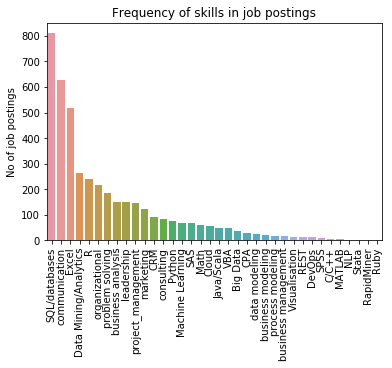

In [36]:
sums_of_skills = results_df.iloc[:, 5:].sum().sort_values(ascending=False)
sns.barplot(x=sums_of_skills.index, y=sums_of_skills)
plt.xticks(rotation=90)
plt.ylabel("No of job postings")
plt.title("Frequency of skills in job postings")
plt.show()

<a id='results_to_file'></a>
## 7. Saving results to a .csv file

Back to the [top](#top)

In [37]:
results_df.to_csv('business_management_analyst_skills.csv')
print("Results have been saved to file 'business_management_analyst_skills.csv'!")

Results have been saved to file 'business_management_analyst_skills.csv'!
